<a href="https://colab.research.google.com/github/jarekwan/BOOTCAMP_Data_Science/blob/main/PROJECT_DATASCIENCE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Introduction

Supplier performance differs in delivery speed, reliability, quality, and cost. Proper segmentation helps identify groups of suppliers with similar characteristics, which supports better procurement decisions, reduces operational risk, and improves supply chain efficiency. Instead of manual, subjective evaluation, data-driven clustering allows companies to quickly detect reliable, risky, or cost-inefficient suppliers.


---

### 2. Business Problem

The goal of this project is to segment suppliers based on performance metrics. This helps detect unreliable or high-defect suppliers, highlight cost-efficient and high-quality ones, and identify risks related to delivery delays. By grouping suppliers automatically, companies can support procurement strategy, plan improvement actions, and make more informed sourcing decisions.


---

### 3. Data Description

The dataset contains numerical features describing different aspects of supplier performance. Each row represents a unique supplier, while the remaining columns store quantitative attributes useful for comparison. These features are suitable for clustering, as they capture variability in supplier behavior and overall performance.


---

### 4. Why This Problem Matters

Supplier segmentation supports better sourcing decisions, helps identify risks, and improves cost and quality control. Without segmentation, important performance differences remain hidden.

---

### 5. Goal of the Analysis

The goal of this analysis is to explore the data, prepare features, reduce dimensionality, and apply clustering methods to identify meaningful supplier groups and extract actionable insights.



### Data Loading

In this step, the dataset is loaded into the notebook. The user can either upload a custom CSV file or generate synthetic supplier data for testing purposes. After loading the data, a unique supplier identifier is selected (or created), and numerical features are extracted for further analysis. This ensures that the dataset is properly structured and ready for exploration and preprocessing.


In [6]:
# Data handling
import pandas as pd
import numpy as np

# File upload support (Colab)
from google.colab import files
import io

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Feature scaling
from sklearn.preprocessing import StandardScaler

# Dimensionality reduction
from sklearn.decomposition import PCA

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN

# Cluster quality metrics
from sklearn.metrics import silhouette_score


# Data source selection
print("Select data source:")
print("1 - Upload CSV file")
print("2 - Generate synthetic data")

choice = input("Enter 1 or 2: ")

if choice == "1":
    # Uploading user dataset
    print("📂 Please select a CSV file...")
    up = files.upload()
    if not up:
        raise ValueError("No file selected.")
    df = pd.read_csv(io.BytesIO(next(iter(up.values()))))
    print("\n✅ CSV file loaded. Shape:", df.shape)
    print(df.head())

    # Selecting supplier ID column
    print("\nAvailable columns:")
    for i, c in enumerate(df.columns):
        print(f"{i}: {c}")
    id_idx = int(input("\nEnter the index of the supplier identifier column: "))
    supplier_col = df.columns[id_idx]

    # Renaming selected column to 'supplier_id'
    df = df.rename(columns={supplier_col: "supplier_id"})
    df["supplier_id"] = df["supplier_id"].astype(str)

    # Selecting numerical features
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

elif choice == "2":
    # Generating synthetic supplier dataset
    n = 2000
    df = pd.DataFrame({
        'supplier_id': [f'S{i}' for i in range(1, n+1)],
        'delivery_time': np.random.normal(5, 1.5, n),
        'reliability': np.random.uniform(0.7, 1.0, n),
        'cost': np.random.normal(100, 15, n),
        'complaints': np.random.randint(0, 5, n)
    })
    print("\n✅ Synthetic dataset generated. Shape:", df.shape)
    print(df.head())

    # Numerical features in synthetic dataset
    num_cols = ['delivery_time', 'reliability', 'cost', 'complaints']

else:
    raise ValueError("❌ Invalid selection. Please restart and enter 1 or 2.")

print("\nℹ️ Proceeding with data analysis...")



Select data source:
1 - Upload CSV file
2 - Generate synthetic data
Enter 1 or 2: 1
📂 Please select a CSV file...


Saving FF.csv to FF (2).csv

✅ CSV file loaded. Shape: (777, 11)
      PO_ID         Supplier  Order_Date Delivery_Date    Item_Category  \
0  PO-00001        Alpha_Inc  2023-10-17    2023-10-25  Office Supplies   
1  PO-00002  Delta_Logistics  2022-04-25    2022-05-05  Office Supplies   
2  PO-00003         Gamma_Co  2022-01-26    2022-02-15              MRO   
3  PO-00004    Beta_Supplies  2022-10-09    2022-10-28        Packaging   
4  PO-00005  Delta_Logistics  2022-09-08    2022-09-20    Raw Materials   

  Order_Status  Quantity  Unit_Price  Negotiated_Price  Defective_Units  \
0    Cancelled      1176       20.13             17.81              NaN   
1    Delivered      1509       39.32             37.34            235.0   
2    Delivered       910       95.51             92.26             41.0   
3    Delivered      1344       99.85             95.52            112.0   
4    Delivered      1180       64.07             60.53            171.0   

  Compliance  
0        Yes  
1  

### Exploratory Data Analysis (EDA)

This section analyzes the dataset before preprocessing and modeling.
The code:

previews the raw data;

checks column types and missing values;

shows descriptive statistics;

automatically detects all numerical columns (excluding supplier_id if numeric);

generates histograms and boxplots with layouts adapting to any number of features;

evaluates skewness of each variable and warns when IQR is not suitable;

applies two outlier detection methods depending on skew:

IQR for symmetric / moderately skewed features,

MAD for strongly skewed ones;

computes and visualizes a correlation matrix (if at least two numeric features);

lists the strongest correlated feature pairs.

Purpose:
to understand distributions, shape, skewness, anomalies and relationships in the data so that scaling, PCA and clustering operate on fully diagnosed inputs.


Data preview:


,PO_ID,supplier_id,Order_Date,Delivery_Date,Item_Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Compliance
0,PO-00001,Alpha_Inc,2023-10-17,2023-10-25,Office Supplies,Cancelled,1176,20.13,17.81,NaN,Yes
1,PO-00002,Delta_Logistics,2022-04-25,2022-05-05,Office Supplies,Delivered,1509,39.32,37.34,235.0,Yes
2,PO-00003,Gamma_Co,2022-01-26,2022-02-15,MRO,Delivered,910,95.51,92.26,41.0,Yes
3,PO-00004,Beta_Supplies,2022-10-09,2022-10-28,Packaging,Delivered,1344,99.85,95.52,112.0,Yes
4,PO-00005,Delta_Logistics,2022-09-08,2022-09-20,Raw Materials,Delivered,1180,64.07,60.53,171.0,No



Data types:
PO_ID                object
supplier_id          object
Order_Date           object
Delivery_Date        object
Item_Category        object
Order_Status         object
Quantity              int64
Unit_Price          float64
Negotiated_Price    float64
Defective_Units     float64
Compliance           object
dtype: object

Missing values per column:
PO_ID                 0
supplier_id           0
Order_Date            0
Delivery_Date        87
Item_Category         0
Order_Status          0
Quantity              0
Unit_Price            0
Negotiated_Price      0
Defective_Units     136
Compliance            0
dtype: int64

Descriptive statistics:


,Quantity,Unit_Price,Negotiated_Price,Defective_Units
count,777.000000,777.000000,777.000000,641.000000
mean,1094.660232,58.283822,53.660721,74.803432
std,647.844551,28.101315,26.094930,69.187870
min,51.000000,10.840000,9.270000,0.000000
25%,615.000000,33.290000,30.460000,26.000000
50%,1075.000000,58.950000,53.800000,49.000000
75%,1548.000000,83.130000,76.550000,100.000000
max,5000.000000,109.170000,107.390000,321.000000


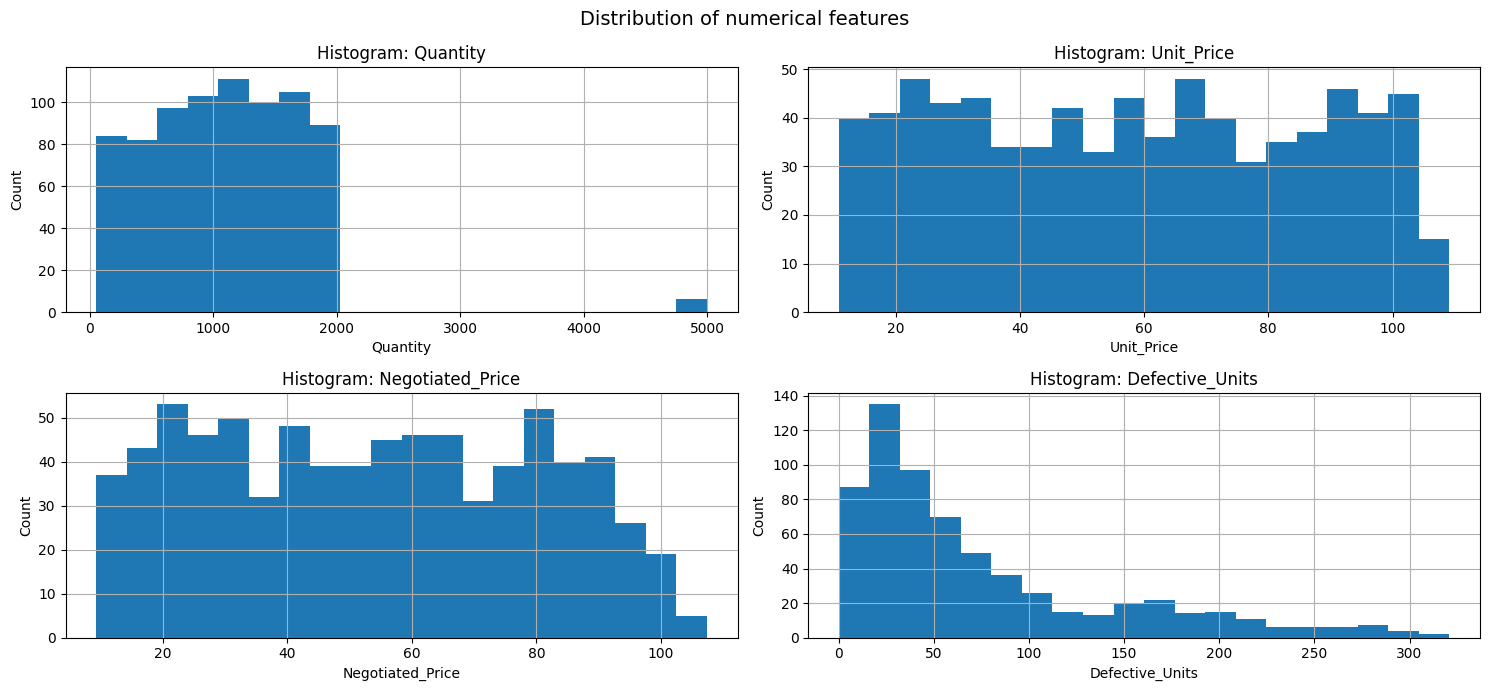

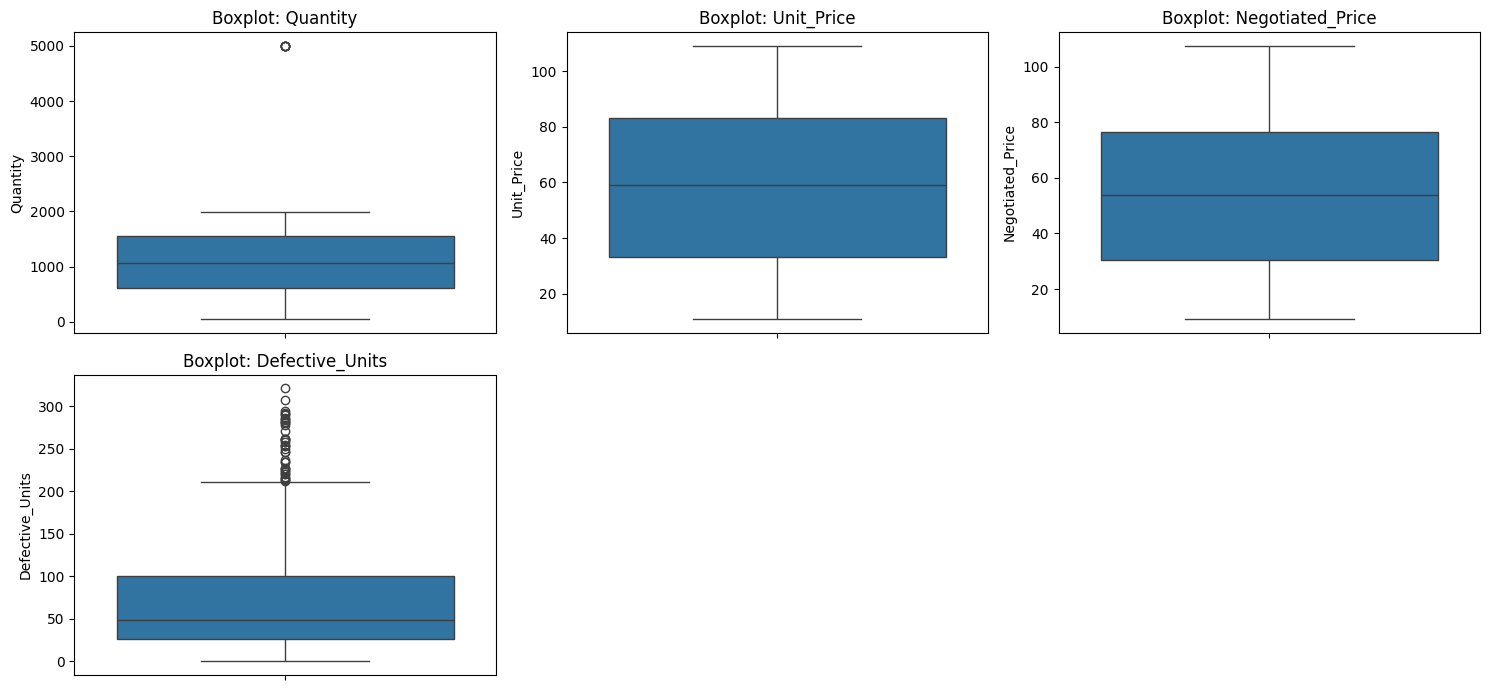


--- Skewness evaluation for numerical columns ---

Skewness for column 'Quantity': skew = 1.55
Strongly skewed distribution — IQR NOT ADEQUATE

Skewness for column 'Unit_Price': skew = 0.03
Distribution nearly symmetric — IQR OK

Skewness for column 'Negotiated_Price': skew = 0.07
Distribution nearly symmetric — IQR OK

Skewness for column 'Defective_Units': skew = 1.38
Strongly skewed distribution — IQR NOT ADEQUATE

Column: Quantity | method: MAD
Number of potential outliers: 6


,supplier_id,Quantity
10,Epsilon_Group,5000
11,Beta_Supplies,5000
12,Beta_Supplies,5000
13,Beta_Supplies,5000
14,Delta_Logistics,5000
15,Beta_Supplies,5000


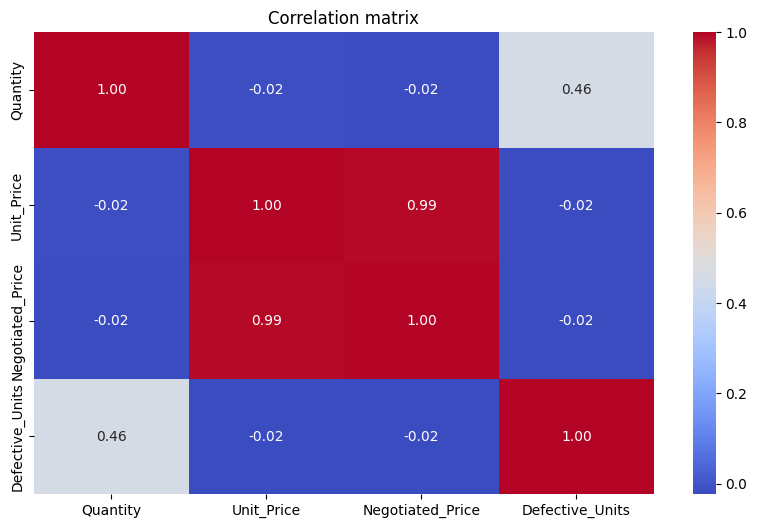


Top correlation pairs:
Unit_Price        Negotiated_Price    0.994602
Negotiated_Price  Unit_Price          0.994602
Defective_Units   Quantity            0.459988
Quantity          Defective_Units     0.459988
Defective_Units   Negotiated_Price    0.023030
dtype: float64

Column: Unit_Price | method: IQR
Number of potential outliers: 0


,supplier_id,Unit_Price


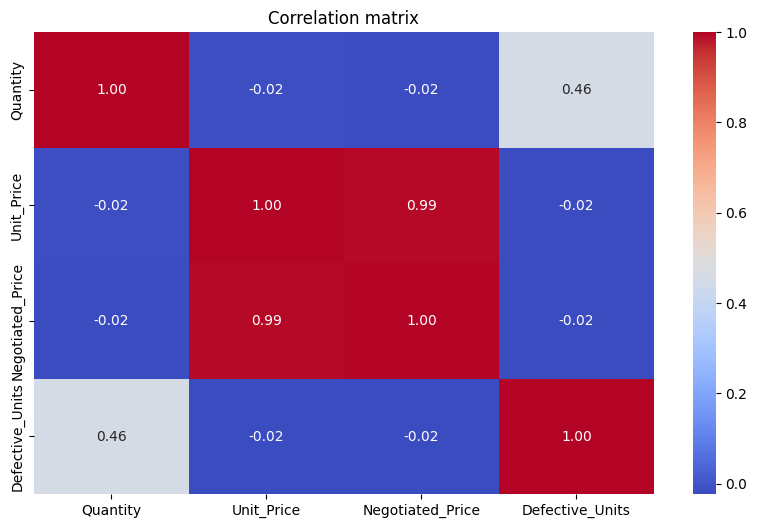


Top correlation pairs:
Unit_Price        Negotiated_Price    0.994602
Negotiated_Price  Unit_Price          0.994602
Defective_Units   Quantity            0.459988
Quantity          Defective_Units     0.459988
Defective_Units   Negotiated_Price    0.023030
dtype: float64

Column: Negotiated_Price | method: IQR
Number of potential outliers: 0


,supplier_id,Negotiated_Price


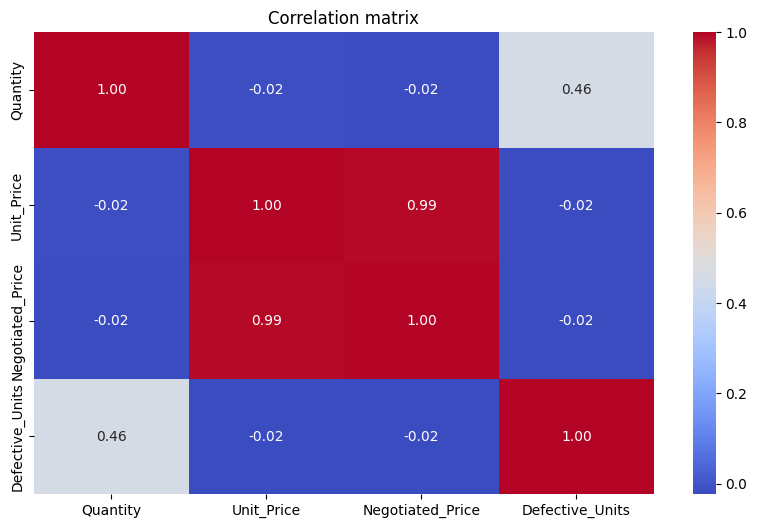


Top correlation pairs:
Unit_Price        Negotiated_Price    0.994602
Negotiated_Price  Unit_Price          0.994602
Defective_Units   Quantity            0.459988
Quantity          Defective_Units     0.459988
Defective_Units   Negotiated_Price    0.023030
dtype: float64

Column: Defective_Units | method: MAD
Number of potential outliers: 71


,supplier_id,Defective_Units
1,Delta_Logistics,235.0
28,Delta_Logistics,187.0
46,Beta_Supplies,191.0
53,Delta_Logistics,262.0
56,Delta_Logistics,206.0
...,...,...
736,Beta_Supplies,198.0
743,Delta_Logistics,226.0
754,Beta_Supplies,207.0
772,Delta_Logistics,262.0


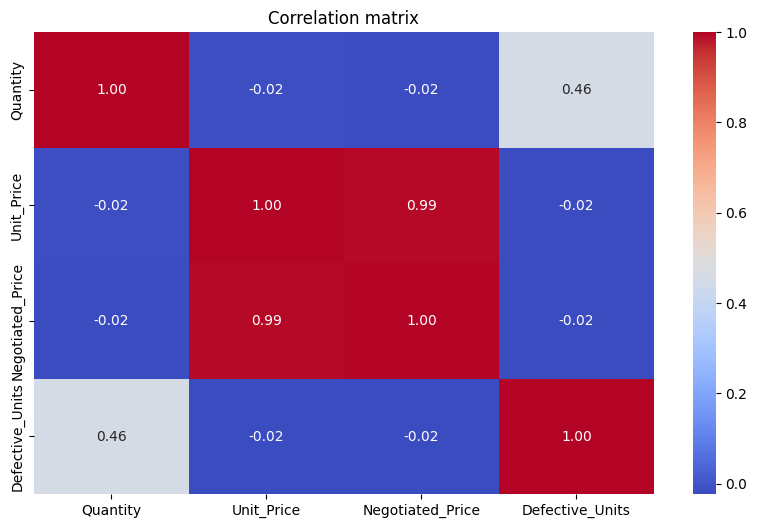


Top correlation pairs:
Unit_Price        Negotiated_Price    0.994602
Negotiated_Price  Unit_Price          0.994602
Defective_Units   Quantity            0.459988
Quantity          Defective_Units     0.459988
Defective_Units   Negotiated_Price    0.023030
dtype: float64


In [7]:
# 2 Exploratory Data Analysis (EDA) – adaptable for any number of numerical columns

# Preview the data
print("Data preview:")
display(df.head())

# Data types and missing values
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic statistics
print("\nDescriptive statistics:")
display(df.describe())

# Numerical columns (exclude supplier_id if numeric)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "supplier_id" in num_cols:
    num_cols.remove("supplier_id")

k = len(num_cols)
if k == 0:
    print("\n[INFO] No numerical columns found — skipping histograms, boxplots, and correlations.")
else:
    # Histograms (grid adjusted to number of features)
    cols = 3 if k >= 3 else (2 if k == 2 else 1)
    rows = int(np.ceil(k / cols))
    axes = df[num_cols].hist(figsize=(5*cols, 3.5*rows), bins=20)

    # Normalize axes structure
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, col in zip(axes, num_cols):
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.set_title(f"Histogram: {col}")

    plt.suptitle("Distribution of numerical features", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Boxplots (grid adjusted to number of features)
    plt.figure(figsize=(5*cols, 3.5*rows))
    for i, col in enumerate(num_cols, 1):
        ax = plt.subplot(rows, cols, i)
        sns.boxplot(y=df[col], ax=ax)
        ax.set_title(f"Boxplot: {col}")
        ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()

    # Skewness evaluation for all numerical columns
    def check_skewness(col):
        skew_val = df[col].skew()
        print(f"\nSkewness for column '{col}': skew = {skew_val:.2f}")

        if abs(skew_val) < 0.5:
            print("Distribution nearly symmetric — IQR OK")
            return "normal"
        elif abs(skew_val) < 1:
            print("Moderately skewed distribution — use IQR with caution")
            return "moderate"
        else:
            print("Strongly skewed distribution — IQR NOT ADEQUATE")
            return "skewed"

    print("\n--- Skewness evaluation for numerical columns ---")
    for c in num_cols:
        check_skewness(c)

# Outlier detection with different method for skewed and non-skewed data
def find_outliers(col):
    skew_val = df[col].skew()

    if abs(skew_val) < 1:
        # IQR for normal / moderately skewed
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask = (df[col] < lower) | (df[col] > upper)
        method = "IQR"
    else:
        # MAD for strongly skewed
        med = df[col].median()
        mad = (df[col] - med).abs().median()
        threshold = 3 * 1.4826 * mad
        mask = (df[col] < med - threshold) | (df[col] > med + threshold)
        method = "MAD"

    cols_to_show = ['supplier_id', col] if 'supplier_id' in df.columns else [col]

    print(f"\nColumn: {col} | method: {method}")
    return df.loc[mask, cols_to_show]

# Run outlier detection for all numerical columns
for c in num_cols:
    out = find_outliers(c)
    print(f"Number of potential outliers: {len(out)}")
    display(out)



    # Correlation matrix (if at least 2 numerical features)
    if len(num_cols) >= 2:
        plt.figure(figsize=(10, 6))
        sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Correlation matrix")
        plt.show()

        corr_matrix = df[num_cols].corr().abs()
        pairs = corr_matrix.unstack().sort_values(ascending=False)
        pairs = pairs[pairs < 1]  # remove diagonal
        print("\nTop correlation pairs:")
        print(pairs.head(5))
    else:
        print("\n[INFO] Not enough numerical columns to compute correlations.")


### Data Preparation

This section prepares the dataset for clustering.
Only numerical features are selected, and supplier_id is removed if it is numeric.
Missing values are filled using the median to avoid distortion from outliers.
All numerical features are then standardized so that each variable has equal weight in PCA and clustering.

Highly correlated features (correlation > 0.9) are optionally removed to reduce redundancy.

After scaling, the script automatically decides whether PCA should be applied:

if the dataset has more than 4 numerical features, PCA is performed and enough components are kept to explain at least 90 percent of variance;

if there are 4 or fewer, PCA is skipped and a PCA-like structure is created to keep the pipeline consistent.

The final output is:

data_pca — the transformed dataset (real PCA or artificial PC columns),

X_final — the version used in all clustering algorit

In [8]:
# 3 Data preparation for modeling

# Copy original dataframe
data_model = df.copy()

# Select numerical columns (if present)
num_cols = data_model.select_dtypes(include=[np.number]).columns

# Remove supplier_id if stored as numeric
if 'supplier_id' in num_cols:
    num_cols = num_cols.drop('supplier_id')

data_model = data_model[num_cols]

# Fill missing values using median
data_model = data_model.fillna(data_model.median())

# Standardize features (important for PCA and clustering)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_model)

# Preserve dataframe structure after scaling
data_scaled = pd.DataFrame(data_scaled, columns=data_model.columns, index=df.index)

print("Scaled data preview (first 5 rows):")
display(data_scaled.head())

# Optionally remove highly correlated features (> 0.9)
corr_matrix = data_scaled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

if len(to_drop) > 0:
    print("\nRemoving highly correlated columns:", to_drop)
    data_scaled = data_scaled.drop(columns=to_drop)
else:
    print("\nNo highly correlated columns detected.")

print("\nFinal shape after preparation:", data_scaled.shape)

# ADDITIONAL CODE FOR PCA AND W/O PCA


# automatic PCA handling depending on number of features

num_features = data_scaled.shape[1]

print("number of numerical features:", num_features)

use_pca = num_features > 4

if not use_pca:
    print("PCA skipped (number of features too small).")

    # create fake PCA structure so later code works unchanged
    data_pca = data_scaled.copy()
    data_pca.columns = [f"PC{i+1}" for i in range(num_features)]

else:
    print("PCA enabled (number of features large).")

    pca_full = PCA()
    pca_full.fit(data_scaled)

    explained_var = np.cumsum(pca_full.explained_variance_ratio_)

    n_components = np.argmax(explained_var >= 0.90) + 1

    print("PCA components kept:", n_components)

    pca = PCA(n_components=n_components)
    data_pca_arr = pca.fit_transform(data_scaled)

    data_pca = pd.DataFrame(
        data_pca_arr,
        columns=[f"PC{i+1}" for i in range(n_components)],
        index=data_scaled.index
    )

X_final = data_pca.copy()

print("final data shape:", X_final.shape)



Scaled data preview (first 5 rows):


,Quantity,Unit_Price,Negotiated_Price,Defective_Units
0,0.125635,-1.358598,-1.374743,-0.334945
1,0.639979,-0.675272,-0.625839,2.591715
2,-0.285221,1.325566,1.480140,-0.460823
3,0.385124,1.480107,1.605149,0.656343
4,0.131814,0.206037,0.263411,1.584692



Removing highly correlated columns: ['Negotiated_Price']

Final shape after preparation: (777, 3)
number of numerical features: 3
PCA skipped (number of features too small).
final data shape: (777, 3)


###  Dimensionality Reduction (PCA)

In this step, Principal Component Analysis (PCA) is applied to reduce the dimensionality of the dataset while preserving most of its variance. PCA transforms the original features into a smaller number of components that capture the dominant patterns in the data. This helps to simplify clustering, reduce noise, and improve visualization. We select the minimum number of components that explain at least 90% of the total variance and use them for further analysis.


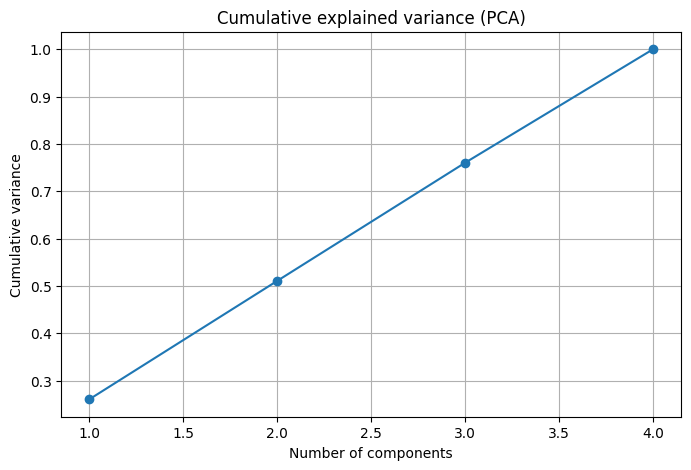

PCA components explaining ≥ 90% variance: 4

PCA-transformed data preview (first 10 rows):


,PC1,PC2,PC3,PC4
0,0.291823,-0.738385,0.358338,1.070651
1,-2.272609,0.069774,-1.263674,-0.129603
2,-0.526642,-0.089624,1.816461,0.968314
3,-0.886002,-1.147249,2.577674,0.191441
4,-0.702993,-0.316371,0.398118,-1.612960
5,1.121561,0.438317,-1.349328,-0.059226
6,0.127346,1.189787,0.944376,-0.663977
7,-0.112355,-0.472392,1.139900,0.549202
8,-0.430108,1.239276,0.177080,-0.495965
9,-1.905008,1.281154,-0.437170,0.781945


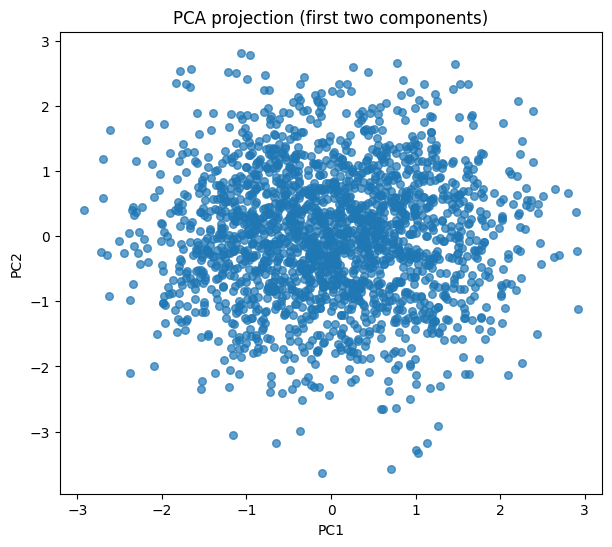

In [ ]:

# #BLOK IS SKIPPED
# # 4 Dimensionality reduction (PCA)

# # Fit PCA on all features (no component limit yet)
# pca_full = PCA()
# pca_full.fit(data_scaled)

# # Cumulative explained variance
# explained_var = np.cumsum(pca_full.explained_variance_ratio_)

# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
# plt.title('Cumulative explained variance (PCA)')
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative variance')
# plt.grid(True)
# plt.show()
# # print(pca_full.explained_variance_ratio_)

# # Choose minimum number of components to explain ≥ 90% variance
# n_components = np.argmax(explained_var >= 0.90) + 1
# print(f"PCA components explaining ≥ 90% variance: {n_components}")

# # Reduce dimensionality
# pca = PCA(n_components=n_components)
# data_pca_arr = pca.fit_transform(data_scaled)

# # Back to DataFrame (preserve index/column names)
# data_pca = pd.DataFrame(
#     data_pca_arr,
#     columns=[f"PC{i+1}" for i in range(n_components)],
#     index=data_scaled.index
# )

# print("\nPCA-transformed data preview (first 10 rows):")
# display(data_pca.head(10))

# # 2D visualization using the first two components (if available)
# if n_components >= 2:
#     plt.figure(figsize=(7, 6))
#     plt.scatter(data_pca['PC1'], data_pca['PC2'], s=30, alpha=0.7)
#     plt.title('PCA projection (first two components)')
#     plt.xlabel('PC1')
#     plt.ylabel('PC2')
#     plt.show()


### Clustering using K-Means (with PCA features)

This section applies the K-Means algorithm to the PCA-transformed feature space.
We evaluate multiple values of k using two diagnostics: the Elbow method (based on WCSS)
and the Silhouette Score, which measures how well each sample fits into its assigned cluster.
Instead of automatically selecting the maximum silhouette score, the user reviews both plots
to choose a realistic and interpretable number of clusters.
After selecting k, the final K-Means model assigns each observation to a cluster,
and the clusters are visualized in two-dimensional PCA space to assess separation and structure.



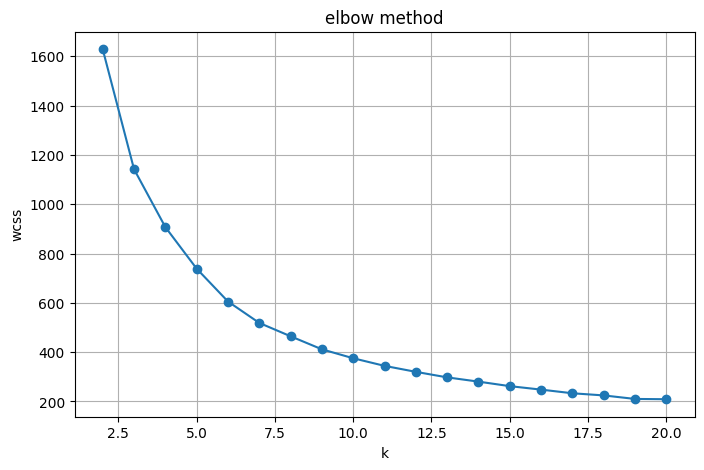

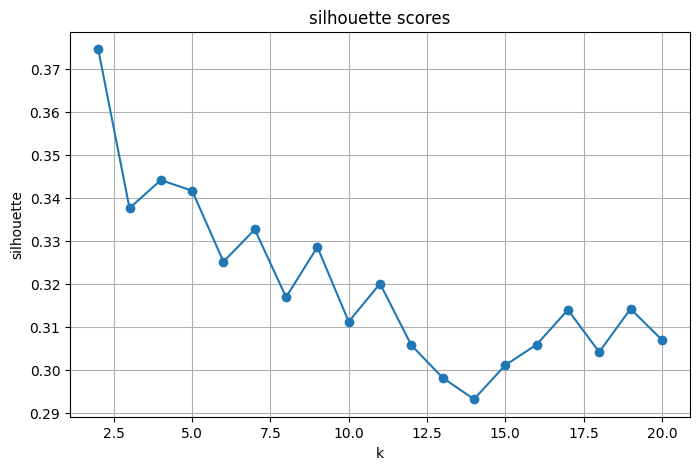

kandydaci według silhouette i elbow: [4, 7, 9, 11, 17, 19]
podaj wybrane k (np. 4 lub 5): 5
liczba obserwacji w klastrach:
Cluster_KMeans
0    265
2    220
1    174
4    112
3      6
Name: count, dtype: int64


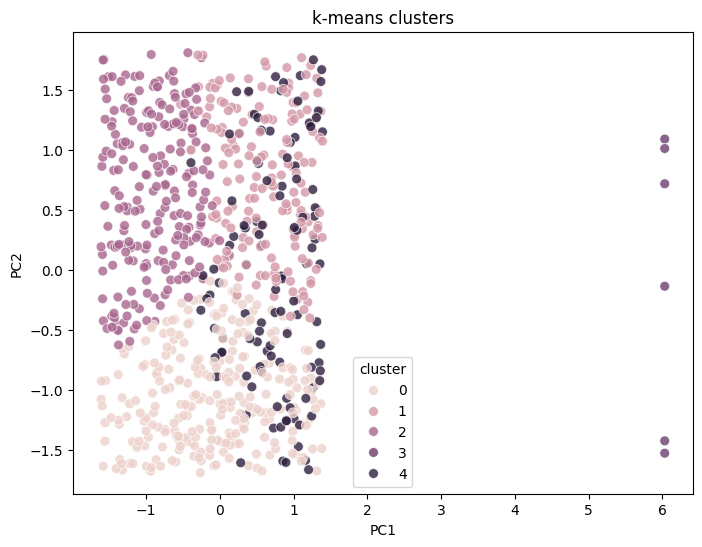

In [14]:
# 5 NEW CODE Clustering — K-Means

X = data_pca.filter(regex='^PC\\d+$').copy()

# elbow method (WCSS)
wcss = []
k_range = range(2, 21)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_range), wcss, marker='o')
plt.title('Elbow method')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# silhouette evaluation
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

plt.figure(figsize=(8, 5))
plt.plot(list(k_range), silhouette_scores, marker='o')
plt.title('Silhouette scores')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()

# guidance: the best k should be:
# - close to the "elbow" on the WCSS plot
# - have high silhouette, but NOT necessarily the maximum

# find local maxima of silhouette (candidates)
import numpy as np
cand = []
for i in range(1, len(silhouette_scores)-1):
    if silhouette_scores[i] > silhouette_scores[i-1] and silhouette_scores[i] > silhouette_scores[i+1]:
        cand.append(k_range[i])

print("Candidates based on silhouette and elbow:", cand)

# manual selection
best_k = int(input("Enter chosen k (e.g., 4 or 5): "))

# final K-Means model
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
data_pca['Cluster_KMeans'] = kmeans_final.fit_predict(X)

print("Number of observations in each cluster:")
print(data_pca['Cluster_KMeans'].value_counts())

# visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster_KMeans',
    data=data_pca,
    s=50, alpha=0.8
)
plt.title('K-Means clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()


### Clustering using DBSCAN

This section applies the DBSCAN algorithm to the PCA-based feature space.
DBSCAN identifies clusters as dense regions of points and marks all low-density
observations as noise. Unlike K-Means, it does not require specifying the number
of clusters in advance, and it can naturally detect irregular cluster shapes.

Several combinations of the parameters *eps* (neighborhood radius) and
*min_samples* (minimum points required to form a dense region) are tested.
Instead of selecting the model with the highest silhouette score, the evaluation
focuses on obtaining a meaningful number of clusters with limited noise, since
DBSCAN often separates dense “core” points from outliers.

After choosing the best parameter pair, the final DBSCAN model assigns each
observation either to a cluster or to noise, and the resulting structure is
visualized in two-dimensional PCA space to assess density-based grouping.



selected dbscan parameters: (0.2, 3)

number of points in each cluster:
Cluster_DBSCAN
-1     297
 4      44
 11     31
 0      29
 15     23
      ... 
 63      3
 49      3
 61      3
 58      3
 60      3
Name: count, Length: 68, dtype: int64


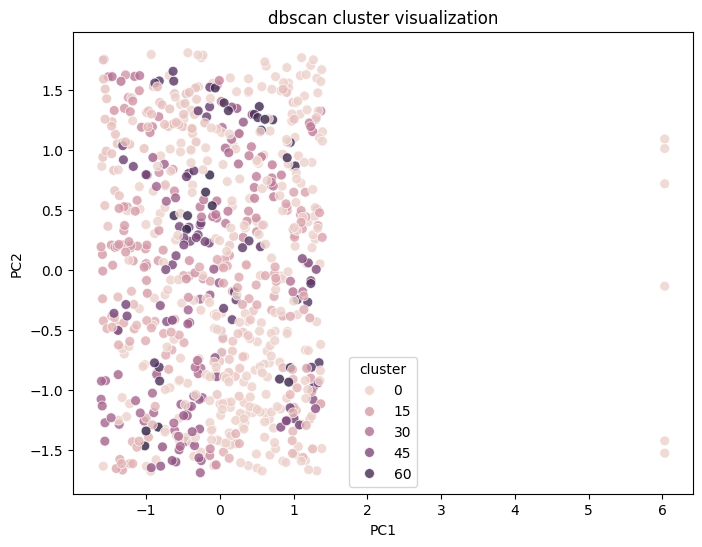

In [12]:
# improved search for best DBSCAN parameters
# 6 clustering — dbscan

# always use X_final, because it contains PCA data or non-PCA data
X = X_final.copy()

# parameters to test
eps_values = [0.2, 0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 10]

best_db = None
best_score = -1
best_params = None

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)

        unique = set(labels)

        # meaningless cases
        if unique == {0, -1}:   # one cluster plus noise
            continue
        if unique == {-1}:      # everything is noise
            continue

        # number of real clusters (exclude -1)
        n_clusters = len([c for c in unique if c != -1])

        # count noise points
        n_noise = list(labels).count(-1)

        # simple evaluation metric (no silhouette)
        score = n_clusters - 0.005 * n_noise

        if score > best_score:
            best_score = score
            best_db = db
            best_params = (eps, ms)

if best_db:
    print("selected dbscan parameters:", best_params)
    data_pca['Cluster_DBSCAN'] = best_db.fit_predict(X)
else:
    print("no valid dbscan clusters found")

# cluster sizes
if 'Cluster_DBSCAN' in data_pca.columns:
    print("\nnumber of points in each cluster:")
    print(data_pca['Cluster_DBSCAN'].value_counts())

    # visualization
    if 'PC1' in data_pca.columns and 'PC2' in data_pca.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x='PC1', y='PC2',
            hue='Cluster_DBSCAN',
            data=data_pca,
            s=50, alpha=0.8
        )
        plt.title('dbscan cluster visualization')
        plt.legend(title='cluster')
        plt.show()



### Cluster Evaluation and Comparison (using PCA)

This section evaluates how well clusters are formed after dimensionality reduction with PCA. Silhouette Scores measure cluster separation quality, while standardized feature profiles help interpret differences between groups. Heatmaps visualize these patterns, and auto-generated labels highlight the most influential features inside each cluster.



=== Silhouette Scores (PCA) ===
K-Means (PCA): 0.344
DBSCAN (PCA): -0.137

=== Cluster profiles (mean z-scores) — K-Means (PCA) ===


,Quantity,Unit_Price,Defective_Units
cluster,,,
0,1.02,0.61,-0.18
1,0.69,0.04,2.00
2,-0.20,-0.98,-0.36
3,-0.78,0.80,-0.52



Cluster profiles — DBSCAN (PCA):


,Quantity,Unit_Price,Defective_Units
cluster,,,
0,0.29,-1.17,-0.31
1,-0.34,1.27,-0.37
2,0.15,0.20,1.63
3,0.20,-0.70,-0.50
4,-1.00,1.19,-0.85
...,...,...,...
62,0.62,1.29,-0.56
63,0.90,-0.89,-0.03
64,-0.50,0.42,0.05


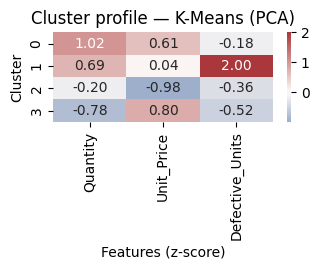

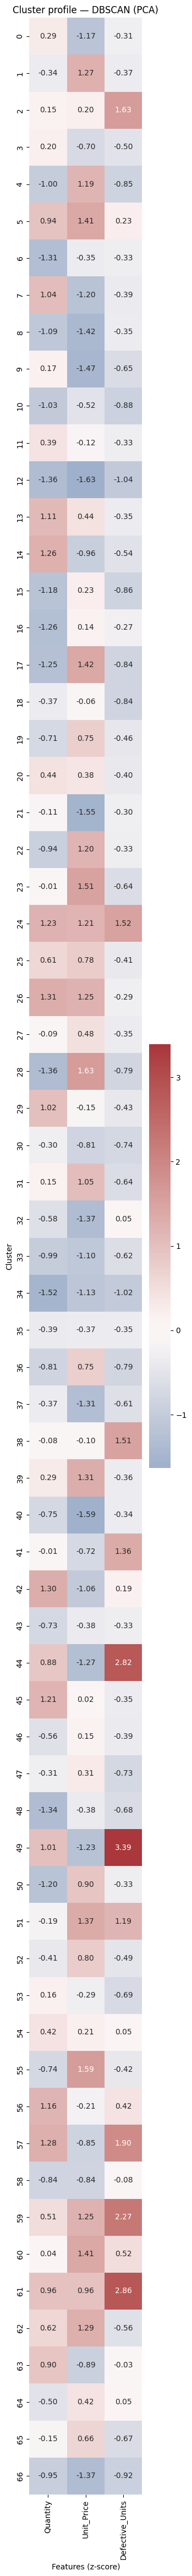


=== Top features by cluster — K-Means (PCA) ===
{0: 'Quantity, Unit_Price', 1: 'Defective_Units, Quantity', 2: 'Unit_Price, Defective_Units', 3: 'Unit_Price, Quantity'}

Top features by cluster — DBSCAN (PCA):
{0: 'Unit_Price, Defective_Units', 1: 'Unit_Price, Defective_Units', 2: 'Defective_Units, Unit_Price', 3: 'Unit_Price, Defective_Units', 4: 'Unit_Price, Quantity', 5: 'Unit_Price, Quantity', 6: 'Quantity, Unit_Price', 7: 'Unit_Price, Quantity', 8: 'Unit_Price, Quantity', 9: 'Unit_Price, Defective_Units', 10: 'Quantity, Defective_Units', 11: 'Quantity, Defective_Units', 12: 'Unit_Price, Quantity', 13: 'Quantity, Unit_Price', 14: 'Quantity, Unit_Price', 15: 'Quantity, Defective_Units', 16: 'Quantity, Defective_Units', 17: 'Unit_Price, Quantity', 18: 'Defective_Units, Quantity', 19: 'Unit_Price, Quantity', 20: 'Quantity, Defective_Units', 21: 'Unit_Price, Defective_Units', 22: 'Unit_Price, Quantity', 23: 'Unit_Price, Defective_Units', 24: 'Defective_Units, Quantity', 25: 'Unit_Pric

In [13]:
# 7 Cluster evaluation and comparison — PCA only

# Silhouette (PCA)
def safe_silhouette(X, labels):
    labs = set(labels)
    if len(labs) < 2 or labs == {-1}:
        return None
    return silhouette_score(X, labels)

print("\n=== Silhouette Scores (PCA) ===")
X_pca = data_pca.filter(regex='^PC')

# K-Means (PCA)
sil_km_pca = safe_silhouette(X_pca, data_pca['Cluster_KMeans'])
print(f"K-Means (PCA): {sil_km_pca:.3f}" if sil_km_pca is not None else "K-Means (PCA): n/a")

# DBSCAN (PCA), if available
if 'Cluster_DBSCAN' in data_pca.columns:
    sil_db_pca = safe_silhouette(X_pca, data_pca['Cluster_DBSCAN'])
    if sil_db_pca is not None:
        print(f"DBSCAN (PCA): {sil_db_pca:.3f}")

# Cluster profiles (mean z-scores) — PCA
def cluster_profile(df_scaled, labels):
    tmp = df_scaled.copy()
    tmp['cluster'] = labels.values
    if -1 in tmp['cluster'].unique():
        tmp = tmp[tmp['cluster'] != -1]
    return tmp.groupby('cluster').mean().round(2)

print("\n=== Cluster profiles (mean z-scores) — K-Means (PCA) ===")
prof_km_pca = cluster_profile(data_scaled, data_pca['Cluster_KMeans'])
display(prof_km_pca)

# DBSCAN profiles (optional)
if 'Cluster_DBSCAN' in data_pca.columns:
    prof_db_pca = cluster_profile(data_scaled, data_pca['Cluster_DBSCAN'])
    if not prof_db_pca.empty:
        print("\nCluster profiles — DBSCAN (PCA):")
        display(prof_db_pca)

# Profile heatmaps — PCA
def plot_heatmap(profile, title):
    if profile is None or profile.empty:
        return
    plt.figure(figsize=(min(12, 1.2*len(profile.columns)), 0.7*len(profile)))
    sns.heatmap(profile, annot=True, cmap='vlag', center=0, fmt='.2f')
    plt.title(title)
    plt.xlabel('Features (z-score)')
    plt.ylabel('Cluster')
    plt.tight_layout()
    plt.show()

plot_heatmap(prof_km_pca, "Cluster profile — K-Means (PCA)")

if 'Cluster_DBSCAN' in data_pca.columns:
    try:
        plot_heatmap(prof_db_pca, "Cluster profile — DBSCAN (PCA)")
    except NameError:
        pass

# Auto labels (top features per cluster)
def auto_labels(profile, top_n=2):
    if profile is None or profile.empty:
        return {}
    labels = {}
    for c in profile.index:
        feats = profile.loc[c].abs().sort_values(ascending=False).head(top_n).index
        labels[c] = ', '.join(feats)
    return labels

print("\n=== Top features by cluster — K-Means (PCA) ===")
print(auto_labels(prof_km_pca))

if 'Cluster_DBSCAN' in data_pca.columns:
    try:
        print("\nTop features by cluster — DBSCAN (PCA):")
        print(auto_labels(prof_db_pca))
    except NameError:
        pass
